# Modeling Notebook + preprocessing + Advanced topic modeling

In [1]:
#Importing necessary packages and libraries
import twint
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffreyng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeffreyng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeffreyng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###  Mean word count per tweet is 33.25 words

In [2]:
#importing more necessary packages
from nltk.tokenize import RegexpTokenizer
import re
import string
from nltk.stem import WordNetLemmatizer 

In [3]:
#scraped CSV into dataframe
df=pd.read_csv('jeff.csv')
df.shape

(7137, 35)

### Using Vader Sentiment Analysis to classify the tweets to be positive, neutral, or negative

In [4]:
#importing the vader sentiment analysis package and instantiating it
data=df
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [5]:
#wrote a function to get the vader scores for my data
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)

In [6]:
#list comprehension to get scores from tweets using my written function
a= [analyser.polarity_scores(x) for x in data['tweet']]

In [7]:
a

[{'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.6597},
 {'neg': 0.319, 'neu': 0.681, 'pos': 0.0, 'compound': -0.7925},
 {'neg': 0.0, 'neu': 0.586, 'pos': 0.414, 'compound': 0.8832},
 {'neg': 0.303, 'neu': 0.577, 'pos': 0.12, 'compound': -0.5859},
 {'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'compound': 0.7825},
 {'neg': 0.162, 'neu': 0.838, 'pos': 0.0, 'compound': -0.8513},
 {'neg': 0.196, 'neu': 0.622, 'pos': 0.182, 'compound': -0.0772},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.196, 'neu': 0.804, 'pos': 0.0, 'compound': -0.6808},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
 {'neg': 0.099, 'neu': 0.901, 'pos': 0.0, 'compound': -0.4515},
 {'neg': 0.0, 'neu': 0.936, 'pos': 0.064, 'compound': 0.0258},
 {'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.7783},
 {'neg': 0.0, 'ne

In [8]:
#pulling the relevant score into a list 
b= [x.items() for x in a]

In [9]:
#creating a dataframe of my vader scores of the tweets
data1=pd.DataFrame(b, columns= ['neg', 'neu', 'pos', 'comp'])

In [10]:
#putting my scores into a column in the dataframe
b = data1['comp']

In [11]:
b

0       (compound, -0.6597)
1       (compound, -0.7925)
2        (compound, 0.8832)
3       (compound, -0.5859)
4        (compound, 0.7825)
               ...         
7132        (compound, 0.0)
7133    (compound, -0.6597)
7134    (compound, -0.4919)
7135     (compound, 0.1007)
7136     (compound, 0.4019)
Name: comp, Length: 7137, dtype: object

In [12]:
#making a column that grabs the right compound score to gauge sentiment
data1['comp2']= [score[1] for score in b]

In [13]:
k=data1['comp2']

In [14]:
#rounding out my vader score
data1['comp2']= data1['comp2'].round(3)

In [15]:
#converting the vader scores into something easier to manipulate so that I can generate 
#three distinct classes
col         = 'comp2'
conditions  = [ data1[col] >= .05, (data1[col] < .05) & (data1[col]> -.05), data1[col] <= -.05 ]
choices     = [ 1, 0, -1 ]
data1["comp3"] = np.select(conditions, choices, default=np.nan)

In [16]:
#final conversion step of the data to equate vader score with the three class of sentiments
data1['comp4']= data1['comp3'].map({-1:'negative', 0: 'neutral', 1:'positive'})

In [17]:
#concating dataframe of useful items for NLP analysis
main_data= pd.concat([data['tweet'], data['language'], data1['comp4']], axis=1, join='outer')

In [18]:
#grabbing only the tweets in English
Work_data= main_data[main_data['language']=='en']

In [19]:
Work_data.head()

,tweet,language,comp4
0,https://twitter.com/drawandstrike/status/1279...,en,negative
1,RACISM IS THE IDOL THAT FEEDS THE BEAST OF #b...,en,negative
2,Powerful picture of the REAL state of race rel...,en,positive
3,Looks like yet another black criminal dealt wi...,en,negative
4,"I SAW YOU ON THE NEWS, KNOW THE TRUTH AND YOUR...",en,positive


In [20]:
Work_data['comp4'].value_counts()

negative    2127
positive    1917
neutral      837
Name: comp4, dtype: int64

### Performing a train, test, split on preprocessed data (no word engineering)

In [21]:
#defining my X variable as well as my target(y)
X= Work_data['tweet']
y= Work_data['comp4']

In [22]:
#train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.20, random_state=23)

In [23]:
X

0        https://twitter.com/drawandstrike/status/1279...
1       RACISM IS THE IDOL THAT FEEDS THE  BEAST OF #b...
2       Powerful picture of the REAL state of race rel...
3       Looks like yet another black criminal dealt wi...
4       I SAW YOU ON THE NEWS, KNOW THE TRUTH AND YOUR...
                              ...                        
7131    For all the #AllLivesMatter people.. I’m gonna...
7133    @ericgarcetti  what did you expect moron? we'r...
7134    Does that mean #DementiaJoe is saying #AllLive...
7135    #PaperMario #PaperMarioTheOrigamiKing #Nintend...
7136     pic.twitter.com/Q1HTj0C8db you can sue for mi...
Name: tweet, Length: 4881, dtype: object

In [24]:
#created a NLP processing function that includes all the steps of corpus cleaning and creation and
# #vectorization
# def NLP_process(data):
#     BoW=[]
#     for word in data:
#         BoW.append(word)
#     word_bank= ' '.join(BoW)
#     word_bank= word_bank.lower()
# #     from nltk.tokenize import RegexpTokenizer
#     tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
#     tokenized_tweets= tokenizer.tokenize(word_bank)

#     sw_list = stopwords.words('english')
#     sw_list += list(string.punctuation)
#     sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
#             'said', 'one', 'com', '-', '–', '—', '.']
#     sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
#             'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
#             'blacklivesmatter' , 'bluelivesmatter', 'p', 'status']
#     sw_set = set(sw_list)
#     filtered_tweets=[]
#     for word in tokenized_tweets:
#         if word not in sw_set:
#             filtered_tweets.append(word)
# #     
#     lemmatizer=WordNetLemmatizer()
#     X_lemmatized_tweets=[]
#     for w in filtered_tweets:
#         X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
# #     return (X_lemmatized_tweets)
    
#     tfidf = TfidfVectorizer(stop_words=sw_list, ngram_range=(1,1), lowercase=True)
#     tfidf_data_train_lem = tfidf.fit_transform(X_lemmatized_tweets)
#     return tfidf_data_train_lem 
#     tfidf_data_test_lem = tfidf.transform(X_test)

    

In [25]:
#created a NLP processing function that includes all the steps of corpus cleaning and creation and
#vectorization

# def NLP_process(data):
#     BoW=[]
#     for word in data:
#         BoW.append(word)
#     word_bank= ' '.join(BoW)
#     word_bank= word_bank.lower()
# #     from nltk.tokenize import RegexpTokenizer
#     tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
#     tokenized_tweets= tokenizer.tokenize(word_bank)

#     sw_list = stopwords.words('english')
#     sw_list += list(string.punctuation)
#     sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
#             'said', 'one', 'com', '-', '–', '—', '.']
#     sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
#             'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
#             'blacklivesmatter' , 'bluelivesmatter', 'p', 'status']
#     sw_set = set(sw_list)
#     filtered_tweets=[]
#     for word in tokenized_tweets:
#         if word not in sw_set:
#             filtered_tweets.append(word)
# #     
#     lemmatizer=WordNetLemmatizer()
#     X_lemmatized_tweets=[]
#     for w in filtered_tweets:
#         X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
#     return (X_lemmatized_tweets)
    
#     tfidf = TfidfVectorizer(stop_words=sw_list, ngram_range=(1,1), lowercase=True)
#     tfidf_data_test_lem = tfidf.transform(X_lemmatized_tweets)
#     return tfidf_data_test_lem 

In [137]:
# processed_data= NLP_process(Work_data['tweet'])
# processed_data
# tfidf_data_test_lem

['drawandstrike',
 'let',
 'know',
 'blm',
 'marxist',
 'scum',
 'marching',
 'little',
 'girl',
 'black',
 'people',
 'murdered',
 'black',
 'people',
 'u',
 'every',
 'year',
 'till',
 'racism',
 'idol',
 'feed',
 'beast',
 'rev',
 'life',
 'powerful',
 'picture',
 'real',
 'state',
 'race',
 'relation',
 'america',
 'god',
 'bless',
 'hero',
 'pasreport',
 'look',
 'like',
 'yet',
 'another',
 'black',
 'criminal',
 'dealt',
 'harsh',
 'manner',
 'deserve',
 'saw',
 'news',
 'know',
 'truth',
 'response',
 'bring',
 'consequence',
 'copyrighted',
 'sermon',
 'system',
 'matter',
 'movement',
 'life',
 'matter',
 'generated',
 'sentence',
 'hijacked',
 'sold',
 'prostituted',
 'blm',
 'holy',
 'abt',
 'u',
 'go',
 'away',
 'r',
 'dr',
 'disagree',
 'u',
 'appear',
 'god',
 'complex',
 'dr',
 'doom',
 'fauci',
 'listen',
 'else',
 'ur',
 'lying',
 'discredit',
 'w',
 'statement',
 'diatribe',
 'make',
 'political',
 'full',
 'racism',
 'simple',
 'amazing',
 'people',
 'able',
 'see',

### Manually implementing the NLP function piece by piece

In [27]:

#creating word bank from tweets
# BoW=[]
# for word in X_train:
#     BoW.append(word)
# len(BoW)

In [28]:
#creating corpus, lowercasing the words, stripping of whitespace
# word_bank= ' '.join(BoW)
# word_bank= word_bank.lower()
# word_bank

In [29]:
#manually tokenizing the corpus
# from nltk.tokenize import RegexpTokenizer
# tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
# tokenized_tweets= tokenizer.tokenize(word_bank)

In [30]:
# tokenized_tweets


In [31]:
#creating stop words to filter our word bank
import string
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—', '.']
sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter', 'p', 'status']
sw_list += [str(x) for x in range(100)]
sw_set = set(sw_list)



In [32]:
#list of stopwords and punctuation
print(set(sw_list))

{'14', '18', 'to', 'hasn', 'same', 'what', '38', 'whom', '2', 'https', 'me', 'was', '93', "didn't", 'one', 'my', 'wouldn', '26', '65', 'o', 'above', 'said', '50', '83', 'between', '–', ':', '“', 'some', '24', 's', '84', '""', 'off', 'ain', 'too', 'has', 'why', "couldn't", '6', 'wasn', 'and', '91', "'", 'very', '86', '28', 'at', '48', 'which', 'hadn', '34', 'couldn', '78', 'nor', 'won', 'does', 'be', '...', '81', 'until', '87', 'herself', '43', 'with', '53', 've', '44', 'now', '88', "shouldn't", 'have', "she's", 'p', '9', '*', "mustn't", "isn't", 'had', '0', '61', 'into', 're', '’', 'themselves', 'than', 'just', '36', 'doing', 'were', 'no', 'shan', 'doesn', '20', '69', 'its', 'once', '#', '$', 'from', "hasn't", '80', 'over', 'mustn', '70', 'didn', 'we', '51', 'in', '@', '_', "wasn't", 'if', '1', 'as', '"', 'are', '68', '64', 'itself', 'any', 'there', '<', '\\', '89', 'shouldn', '40', '90', 'them', 'on', 'com', '37', '32', 'their', 'these', "should've", "won't", 'www', '21', 'his', '8', 

In [33]:
#filtering out stopwords
# filtered_tweets=[]
# for word in tokenized_tweets:
#     if word not in sw_set:
#         filtered_tweets.append(word)

In [34]:
#lemmatizing
# from nltk.stem import WordNetLemmatizer 
# lemmatizer=WordNetLemmatizer()
# X_lemmatized_tweets=[]
# for w in filtered_tweets:
#     X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
# print (X_lemmatized_tweets)

In [35]:
#using function to process my data
# X_train= NLP_process(X_train)
# y_train=NLP_process(y_train)

In [36]:
#using function to process data
# X_test=NLP_process(X_test)

### Vectorizing tf-idf and creating the Document Term Matrix

In [37]:
#using tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words=sw_set, ngram_range=(1,3), lowercase=True)
tfidf_data_train_lem = tfidf.fit_transform(X_train)
tfidf_data_test_lem = tfidf.transform(X_test)

dfq = pd.DataFrame(tfidf_data_test_lem.toarray().T,
                 index = tfidf.vocabulary_.keys())
dfq1=dfq.T

In [38]:

m=[dfq1.iloc[i].idxmax() for i in range(977)]



In [39]:
len(m)

977

In [40]:
tuple_S=(zip(y_test, m))


In [41]:
tuple_S

In [42]:
dfq1

,fund,defense,trump2020landslidevictory,fund defense,defense trump2020landslidevictory,fund defense trump2020landslidevictory,lives,matter,dems,ever,...,fridaythoughts harden,harden nbabubble,person allblacklivesmatter mutually,allblacklivesmatter mutually exclusive,mutually exclusive black,exclusive black minority,black minority police,minority police fridaythoughts,police fridaythoughts harden,fridaythoughts harden nbabubble
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# dict_A=dict(zip(y_test,m))
# len(dict_A)

In [44]:
# Dataframe=pd.DataFrame(dict_A, index= ['sentiment']).T

In [45]:
# dfs=Dataframe.reset_index()
# dfs

In [46]:
# dict_w= dict(zip(dict_A.values(),dict_A.keys()))
# next_list=[]
# for key in dict_A.keys():
#     if len(key)<1000:
#         next_list.append(key)
# len(next_list)


### Classifying the tweets with a baseline + three models (RF,NB, SVM)

#### Baseline Model

In [47]:
#count vectorizing data for dummy classifier
vec=CountVectorizer(stop_words=sw_set, ngram_range=(1,3), lowercase=True)
X_b=vec.fit_transform(X_train)
X_test_b=vec.transform(X_test)

In [48]:
#fitting and predicting the dummy classifier (baseline model)
from sklearn.dummy import DummyClassifier
dclf = DummyClassifier() 
dclf.fit(X_b, y_train)
y_preds_b=dclf.predict(X_test_b)

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [49]:
#printing the evaluation metrics for the dummy classifier
print(metrics.accuracy_score(y_test, y_preds_b))
print(metrics.precision_score(y_test, y_preds_b, average='weighted'))
print(metrics.recall_score(y_test, y_preds_b, average='weighted'))
print(metrics.f1_score(y_test, y_preds_b, average='weighted'))


0.43091095189355166
0.43798750159229904
0.43091095189355166
0.4337476069373151


#### Random Forest Model

In [50]:
#initializing RandomForest 
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=0, n_jobs=-1)

In [51]:
#fitting model
rfc.fit(tfidf_data_train_lem, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [52]:
tfidf_data_test_lem.shape

(977, 55012)

In [53]:
rfc_cv= RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=0, n_jobs=-1)

In [54]:
rfc_cv.fit(X_b, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [55]:
rfc_cv_preds=rfc_cv.predict(X_test_b)

In [56]:
print(metrics.accuracy_score(y_test, rfc_cv_preds))
print(metrics.precision_score(y_test, rfc_cv_preds, average='weighted'))
print(metrics.recall_score(y_test, rfc_cv_preds, average='weighted'))
print(metrics.f1_score(y_test, rfc_cv_preds, average='weighted'))


0.9078812691914022
0.9130323479855319
0.9078812691914022
0.9088486261966691


In [57]:
#predicting model
rfc_preds= rfc.predict(tfidf_data_test_lem[0:700])
rfc_preds_h= rfc.predict(tfidf_data_test_lem[700: ])

In [58]:
#printing out evaluation metrics
print(metrics.accuracy_score(y_test[0:700], rfc_preds))
print(metrics.precision_score(y_test[0:700], rfc_preds, average='weighted'))
print(metrics.recall_score(y_test[0:700], rfc_preds, average='weighted'))
print(metrics.f1_score(y_test[0:700], rfc_preds, average='weighted'))



0.8857142857142857
0.8945530874102302
0.8857142857142857
0.8878089311195666


In [59]:
#printing out evaluation metrics
print(metrics.accuracy_score(y_test[700: ], rfc_preds_h))
print(metrics.precision_score(y_test[700: ], rfc_preds_h, average='weighted'))
print(metrics.recall_score(y_test[700: ], rfc_preds_h, average='weighted'))
print(metrics.f1_score(y_test[700: ], rfc_preds_h, average='weighted'))

0.8880866425992779
0.8991531706735516
0.8880866425992779
0.8908103154917222


In [60]:
#a comparison of the counts of prediction and actual 
pd.Series(y_test).value_counts()

negative    453
positive    366
neutral     158
Name: comp4, dtype: int64

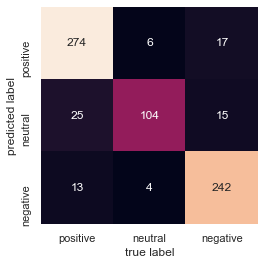

In [61]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test[0:700], rfc_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

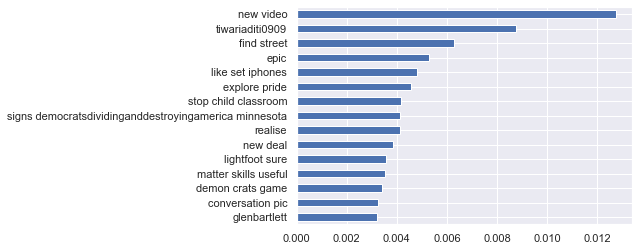

In [62]:
feat_importances= pd.Series(rfc.feature_importances_,index=tfidf.vocabulary_)
feat_importances.nlargest(15).sort_values().plot(kind='barh')
plt.savefig('RFC_feature_importance.png')

#### Multinomial Naive Bayes Model

In [63]:
#Naive Bayes Classifier 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.01, fit_prior=False)

In [64]:
#fitting model with tf_idf vectorized data
clf.fit(tfidf_data_train_lem, y_train)

MultinomialNB(alpha=0.01, fit_prior=False)

In [65]:
#predicting model

clf_preds= clf.predict(tfidf_data_test_lem[0:700])
clf_preds_h= clf.predict(tfidf_data_test_lem[700: ])

In [66]:
#evaluation metrics
print(metrics.accuracy_score(y_test[0:700], clf_preds))
print(metrics.precision_score(y_test[0:700], clf_preds, average='weighted'))
print(metrics.recall_score(y_test[0:700], clf_preds, average='weighted'))
print(metrics.f1_score(y_test[0:700], clf_preds, average='weighted'))

0.8914285714285715
0.8920649333334153
0.8914285714285715
0.8912544262460229


In [67]:
print(metrics.accuracy_score(y_test[700: ], clf_preds_h))
print(metrics.precision_score(y_test[700: ], clf_preds_h, average='weighted'))
print(metrics.recall_score(y_test[700: ], clf_preds_h, average='weighted'))
print(metrics.f1_score(y_test[700: ], clf_preds_h, average='weighted'))

0.8844765342960289
0.8846549931645342
0.8844765342960289
0.884021964798138


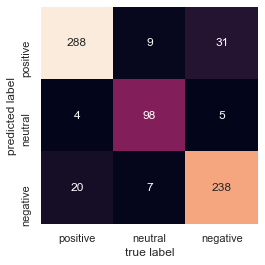

In [68]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test[0:700], clf_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

#### SVM Model

In [69]:
#starting SVM model
from sklearn import svm

In [70]:
#setting hyperparameters for the SVM model
svm_clf = svm.SVC(kernel='linear', C=10, class_weight='balanced')

In [71]:
#fitting the SVM model
svm_clf.fit(tfidf_data_train_lem, y_train)

SVC(C=10, class_weight='balanced', kernel='linear')

In [72]:
#predicting the classification with SVM
svm_preds=svm_clf.predict(tfidf_data_test_lem[0:700])
svm_preds_h=svm_clf.predict(tfidf_data_test_lem[700: ])

In [73]:
#Evaluation metrics
print(metrics.accuracy_score(y_test[0:700], svm_preds))
print(metrics.precision_score(y_test[0:700], svm_preds, average='weighted'))
print(metrics.recall_score(y_test[0:700], svm_preds, average='weighted'))
print(metrics.f1_score(y_test[0:700], svm_preds, average='weighted'))

0.9057142857142857
0.9071234674068325
0.9057142857142857
0.9054277510840266


In [74]:
print(metrics.accuracy_score(y_test[700: ], svm_preds_h))
print(metrics.precision_score(y_test[700: ], svm_preds_h, average='weighted'))
print(metrics.recall_score(y_test[700: ], svm_preds_h, average='weighted'))
print(metrics.f1_score(y_test[700: ], svm_preds_h, average='weighted'))

0.8989169675090253
0.8987889779990723
0.8989169675090253
0.8985030745997034


In [75]:
svm_clf_cv=svm.SVC(kernel='linear', C=10, class_weight='balanced')

In [76]:
svm_clf_cv.fit(X_b, y_train)

SVC(C=10, class_weight='balanced', kernel='linear')

In [77]:
svm_clf_cv_preds=svm_clf_cv.predict(X_test_b)

In [78]:
print(metrics.accuracy_score(y_test, svm_clf_cv_preds))
print(metrics.precision_score(y_test, svm_clf_cv_preds, average='weighted'))
print(metrics.recall_score(y_test, svm_clf_cv_preds, average='weighted'))
print(metrics.f1_score(y_test, svm_clf_cv_preds, average='weighted'))

0.8915046059365405
0.9022530681828066
0.8915046059365405
0.8935456142888119


## Getting the SVM coefficients of the count_vectorized data

In [79]:
svm_clf_cv.coef_.T.shape
data4=vec.get_feature_names()

In [80]:
df_CV=pd.DataFrame(svm_clf.coef_.T.todense(), index= data4)

In [81]:
df_CV

,0,1,2
000,0.043093,-0.346030,-0.308768
000 federal,0.048972,0.071370,0.000000
000 federal inmates,0.048972,0.071370,0.000000
000 get,0.000000,-0.149854,-0.115579
000 get help,0.000000,-0.149854,-0.115579
...,...,...,...
سرايا_السلام pic,0.064302,0.084723,0.000000
سرايا_السلام pic zmruclqlf2,0.064302,0.084723,0.000000
태민아_짝궁들이_생일축하한대,-0.278262,0.000000,0.264403
태민아_짝궁들이_생일축하한대 pic,-0.278262,0.000000,0.264403


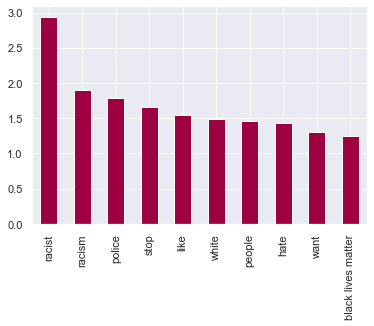

In [82]:
df_CV[0].sort_values(ascending=False).head(10).plot(kind='bar', cmap='Spectral')

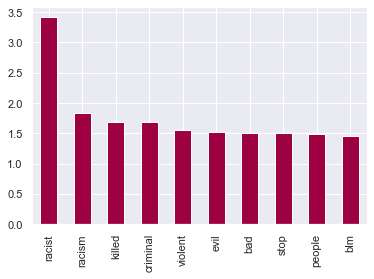

In [83]:
df_CV[1].sort_values(ascending=False).head(10).plot(kind='bar', cmap='Spectral')

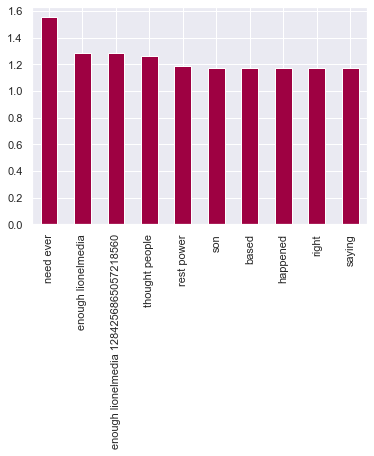

In [84]:
df_CV[2].sort_values(ascending=False).head(10).plot(kind='bar', cmap='Spectral')

## Getting the SVM coefficients for each class 

In [85]:
svm_clf=svm.SVC(kernel='linear', C=10)

In [86]:
svm_clf.fit(tfidf_data_train_lem, y_train)

SVC(C=10, kernel='linear')

In [87]:
svm_clf.coef_.T.shape
data3=tfidf.get_feature_names()

In [88]:
len(data3)

55012

In [89]:
svm_clf.coef_.T.shape

(55012, 3)

In [90]:
data2=pd.DataFrame(svm_clf.coef_.T.todense(), index= data3)

data2.rename(columns={0:'positive', 1:'negative', 2:'neutral'}, inplace=True)


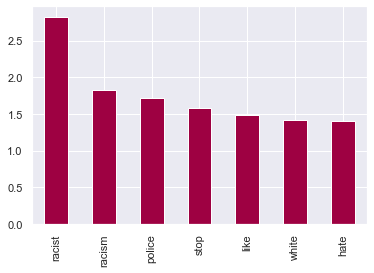

In [91]:
data2['positive'].sort_values(ascending=False).head(7).plot(kind='bar', cmap='Spectral')


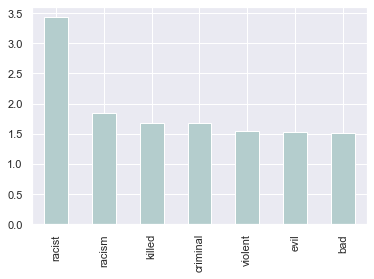

In [92]:
data2['negative'].sort_values(ascending=False).head(7).plot(kind='bar', color = '#B4CDCD')

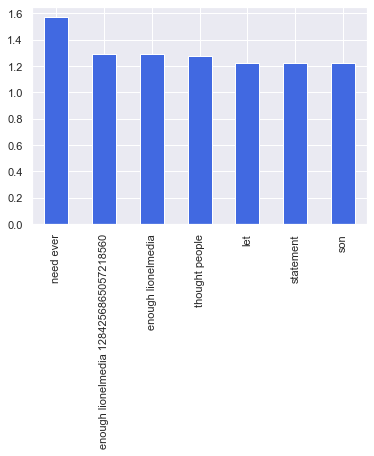

In [93]:
data2['neutral'].sort_values(ascending=False).head(7).plot(kind='bar', color= '#4169E1' )

In [94]:
# result=pd.read_csv('twitter.csv')

In [95]:
# result['tweet']

In [96]:
# result_main= result[result['language']=='en']

In [97]:
# result_main['language'].value_counts()

In [98]:
# holdout_result=NLP_process(result_main['tweet'])

In [99]:
# c= [analyser.polarity_scores(x) for x in result_main['tweet']]

In [100]:
# d= [x.items() for x in a]

In [101]:
# data2=pd.DataFrame(d, columns= ['neg', 'neu', 'pos', 'comp'])

In [102]:
# e = data2['comp']

In [103]:
# data2['comp2']= [score[1] for score in e]

In [104]:
# data2['comp2']= data2['comp2'].round(3)

In [105]:
#converting the vader scores into something easier to manipulate so that I can generate 
#three distinct classes
# col         = 'comp2'
# conditions  = [ data2[col] >= .05, (data2[col] < .05) & (data2[col]> -.05), data2[col] <= -.05 ]
# choices     = [ 1, 0, -1 ]
# data2["comp3"] = np.select(conditions, choices, default=np.nan)

In [106]:
# data2['comp4']= data2['comp3'].map({-1:'negative', 0: 'neutral', 1:'positive'})

In [107]:
# data2['comp4'].value_counts()

In [108]:
# y_holdout=data2['comp4']

In [109]:
# X_holdout=result['tweet']

In [110]:
# tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), lowercase=True)
# tfidf_holdout_set = tfidf.fit_transform(X_holdout)
# # tfidf_holdout_set = tfidf.transform(X_holdout)

# # tfidf_data_train_lem
# dfq1 = pd.DataFrame(tfidf_holdout_set.toarray().transpose(),
#                  index = tfidf.get_feature_names())

# The rest of NB deals with advanced NLP topics

In [111]:
import spacy
import pandas as pd
import numpy as np
from tqdm import tqdm

In [112]:
tqdm.pandas()

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [113]:
Work_data

,tweet,language,comp4
0,https://twitter.com/drawandstrike/status/1279...,en,negative
1,RACISM IS THE IDOL THAT FEEDS THE BEAST OF #b...,en,negative
2,Powerful picture of the REAL state of race rel...,en,positive
3,Looks like yet another black criminal dealt wi...,en,negative
4,"I SAW YOU ON THE NEWS, KNOW THE TRUTH AND YOUR...",en,positive
...,...,...,...
7131,For all the #AllLivesMatter people.. I’m gonna...,en,negative
7133,@ericgarcetti what did you expect moron? we'r...,en,negative
7134,Does that mean #DementiaJoe is saying #AllLive...,en,negative
7135,#PaperMario #PaperMarioTheOrigamiKing #Nintend...,en,positive


## Attempting to use SpaCY

In [114]:
nlp = spacy.load('en_core_web_md')

In [115]:
Work_data['spacy_txt'] = [nlp(x) for x in Work_data['tweet']]

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
#made a column containing a spacy object
Work_data['spacy_y']= [nlp(x) for x in Work_data['comp4']]

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [117]:
# corpus = []
# for doc in nlp_df.clean_tweet:
#     d = (list(filter(lambda x: x.is_stop==False,nlp(doc))))
#     d = (list(filter(lambda x: x.is_punct==False, d)))
#     d = (list(filter(lambda x: x.like_url==False, d)))
#     d = (list(map(lambda x: x.lemma_, d)))
#     corpus.append(d)

In [118]:
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—', '.']
sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter', 'p']
sw_set = set(sw_list)

In [119]:
Work_data.spacy_txt[0] 

 https://twitter.com/drawandstrike/status/1279805238556397569?s=19 …

Let me know when BLM marxist scum is marching for this little girl and the 6000+ black people murdered by other black people in the US every year. Till then... #AllLivesMatter

In [120]:
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [129]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
# nlp = spacy.load('en')
# stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words = sw_list

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower() for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [122]:
Work_data['spacy_txt']=[spacy_tokenizer(x) for x in Work_data['tweet']]

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [123]:
Work_data['spacy_txt']

0       [https://twitter.com/drawandstrike/status/1279...
1          [racism, idol, feeds, beast, rev, 13:17, life]
2       [powerful, picture, real, state, race, relatio...
3       [looks, like, yet, another, black, criminal, d...
4       [saw, news, know, truth, response, bring, cons...
                              ...                        
7131    [people, .., go, sit, right, let, sink, 🤨, yea...
7133    [@ericgarcetti, expect, moron, middle, pandemi...
7134    [mean, dementiajoe, saying, cancel, culture, r...
7135    [papermario, papermariotheorigamiking, nintend...
7136    [pic.twitter.com/q1htj0c8db, sue, millions, ne...
Name: spacy_txt, Length: 4881, dtype: object

In [124]:
X = Work_data['spacy_txt'] # the features we want to analyze
ylabels = Work_data['comp4'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2)

In [139]:

from sklearn.pipeline import pipeline
classifier = RandomForestClassifier(n_jobs=-1)
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)
# Create pipeline using Bag of Words
# pipe = Pipeline([
#                 ('vectorizer', tfidf_vector),
#                  ('classifier', classifier)])

# model generation
Classifier.train(X_train,y_train)

ImportError: cannot import name 'pipeline' from 'sklearn.pipeline' (/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py)

In [143]:
tfidf_vector=TfidfVectorizer()

In [145]:
# tfidf_data = tfidf_vector.fit_transform(X_train)
# tfidf_data_test= tfidf_vector.transform(X_test)
tfidf_vec = TfidfVectorizer(stop_words=sw_set, ngram_range=(1,3), lowercase=True)
tfidf_data_train_lem = tfidf_vec.fit_transform(X_train)
tfidf_data_test_lem = tfidf_vec.transform(X_test)


AttributeError: 'list' object has no attribute 'lower'

In [138]:
X_train

3865    [want, understand, dictatorship, looks, like, ...
4930    [’s, unacceptable, antifa, black, lives, matte...
6961                                 [know, pissed, much]
6215    [deflecting, exactly, like, saying, right, som...
4093    [thought, white, people, bad, hour, four, stra...
                              ...                        
6991    [even, though, virus, fake, glad, see, help, p...
5113    [totally, professional, could, never, speak, t...
1676    [@jharden13, come, man, mask, back, mob, man, ...
3721    [disgraceful, words, san, francisco, police, c...
6539                                              [based]
Name: spacy_txt, Length: 3904, dtype: object

In [ ]:
pd.DataFrame(np.vstack([x.vector for x in Work_data.spacy_txt]))

In [ ]:
X=Work_data.spacy_txt
y=Work_data.spacy_y

In [ ]:
def mean_tweet_length(X):
    for token in X:
        print (token.__len__())

## Topic Modeling using LDA and NMF

In [146]:
#First we vectorize data
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=sw_list, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(Work_data['tweet'])
data_vectorized.shape

(4881, 2349)

In [147]:
#select number of topics or clusters of data
NUM_TOPICS = 3

In [148]:
#importing libraries
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

In [149]:
#instantiating lda model with certain hyperparamters
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, n_jobs=-1, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)


iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [150]:
#function that returns the topic and important features to that topic
def selected_topics(model, vectorizer, top_n=15):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 


In [151]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('lives', 570.6984210528963), ('black', 496.86312702356895), ('matter', 454.4821341138039), ('status', 376.4006700062616), ('people', 320.1062665174123), ('racist', 227.56156497417783), ('blm', 183.5891674876815), ('white', 177.2180061582895), ('racism', 165.51625169574), ('pic', 156.05321405311196), ('know', 127.47889288492156), ('love', 125.36390958302738), ('life', 121.49973914015574), ('say', 120.93280581906352), ('right', 115.60556460549874)]
Topic 1:
[('status', 651.43278866631), ('trump', 445.0619945713232), ('pic', 336.43183025578173), ('people', 225.0593083290827), ('maga', 175.44466324374255), ('like', 169.57439423267303), ('backtheblue', 150.45386552176444), ('stop', 143.95316338436075), ('wwg', 132.7631843513183), ('support', 122.36796171758851), ('blmterrorists', 109.79714535122207), ('left', 105.33948457763148), ('wga', 102.63797431348432), ('let', 102.40454718058774), ('covid', 99.35933416639423)]
Topic 2:
[('realdonaldtrump', 447.4402190589659), ('p

In [152]:
#created dictionary of lda components and the words
a= dict(zip(vectorizer.get_feature_names(), lda.components_[0]))

In [153]:
#sorted dictionary from highest to lowest
sort_ordersa = sorted(a.items(), key=lambda x: x[1], reverse=True)


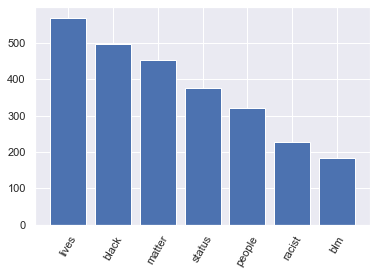

In [154]:
#graph of topic 0
#POSITIVE SENTIMENT
a=dict(sort_ordersa[0:7])
F, G = zip(*a.items()) # unpack a list of pairs into two tuples
plt.savefig('LDApos1.png')
plt.bar(F, G)
plt.xticks(rotation=60)
plt.show()

In [155]:
lda.components_

array([[ 5.8837819 ,  0.33732858,  3.30981861, ...,  7.35138869,
         0.33344951,  0.34233137],
       [ 0.33357276,  0.33525602,  0.36754785, ...,  0.33523761,
         0.33353712,  0.33980705],
       [ 0.33359288, 26.69676279, 40.09908451, ..., 26.59895325,
        13.007238  ,  6.99920055]])

In [156]:
#Instantiating the NMF model with certain hyperparamters
nmf=NMF(n_components = NUM_TOPICS, random_state =1, alpha=0.1, l1_ratio = 0.5, 
        init= 'nndsvd').fit(data_vectorized)

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [157]:
# returning topic and important words associated with the topic
print("NMF Model:")
selected_topics(nmf, vectorizer)

NMF Model:
Topic 0:
[('lives', 5.844655232342381), ('black', 4.83530550054908), ('matter', 4.825281211290751), ('people', 1.1763357651513195), ('white', 1.0968776080180784), ('say', 0.5158146309819348), ('even', 0.4502133509151366), ('life', 0.36795780723059607), ('racist', 0.34009217136396885), ('saying', 0.33218353264158396), ('utm', 0.3058112219284762), ('matters', 0.2810986007766448), ('like', 0.2803740313019304), ('blacks', 0.2781814697127207), ('blue', 0.2572378682955275)]
Topic 1:
[('blm', 3.600133988178728), ('pic', 3.5124199698870364), ('realdonaldtrump', 3.4526532271019392), ('cspanwj', 2.225088800460473), ('news', 2.1316046227823295), ('facebook', 2.1157901703138524), ('breakingnews', 2.0637462503414925), ('breaking', 1.6053156477099073), ('teaparty', 1.5578033093641261), ('hate', 1.4574009788692899), ('tcot', 1.2813319104108356), ('racist', 1.2728999094263551), ('terrorist', 1.0462154886797208), ('group', 0.9696626332919562), ('target', 0.9422964794312984)]
Topic 2:
[('stat

In [158]:
#created a dictionary 
g=dict(zip(vectorizer.get_feature_names(), lda.components_[1]))  
g

{'--atuq': 0.33357276199612157,
 '-cops-protect-black-lives-matter-mural': 0.3352560198806306,
 'abcnews': 0.36754785335351753,
 'abiding': 0.3611292117002938,
 'ability': 14.664309535890876,
 'able': 6.36250614152873,
 'aboriginallivesmatter': 6.1568648327963995,
 'abortion': 2.461170992849202,
 'abortionismurder': 5.058558589514342,
 'absolute': 5.720245867492503,
 'absolutely': 9.779152788401236,
 'abt': 3.1622995387002693,
 'abused': 0.3352544269701818,
 'acab': 5.906981411791381,
 'accepted': 0.337964163463663,
 'account': 8.270996170462247,
 'across': 5.335657678599361,
 'act': 17.936324817037267,
 'actions': 1.5568007502779944,
 'activists': 0.34289859321152566,
 'acts': 5.968617500586447,
 'actual': 4.6004810907139575,
 'actually': 13.605295699578456,
 'add': 9.110348425372417,
 'afp': 6.386794886036245,
 'afraid': 0.3377771488658006,
 'africa': 14.150212498679279,
 'african': 11.256197101388699,
 'african-americans': 6.116948490382379,
 'agbecerra': 12.678606403505801,
 'age':

In [159]:
#sorted thru dictionary grom highest to lowest
sort_ordersp = sorted(g.items(), key=lambda x: x[1], reverse=True)


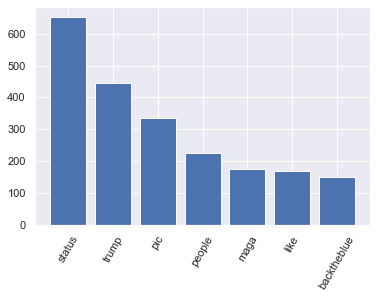

In [160]:
#NEGATIVE SENTIMENT
#graph of the words in topic 1
p=dict(sort_ordersp[0:7])
F, G = zip(*p.items()) # unpack a list of pairs into two tuples
plt.savefig('LDAneg1.png')
plt.bar(F, G)
plt.xticks(rotation=60)
plt.show()

In [161]:
o=dict(zip(vectorizer.get_feature_names(), lda.components_[2]))  
o

{'--atuq': 0.3335928807625293,
 '-cops-protect-black-lives-matter-mural': 26.696762791153674,
 'abcnews': 40.099084510333554,
 'abiding': 6.467304476443655,
 'ability': 0.35373691861076073,
 'able': 0.3698414399574079,
 'aboriginallivesmatter': 0.4449758370501411,
 'abortion': 0.3528452437643132,
 'abortionismurder': 0.3336683433783015,
 'absolute': 0.38239296972434605,
 'absolutely': 4.930395819957408,
 'abt': 0.33366132253349307,
 'abused': 0.34798729202521717,
 'acab': 0.3621934505571604,
 'accepted': 0.34813111200465807,
 'account': 0.3341688332156265,
 'across': 0.3566543121141937,
 'act': 0.42305165593747546,
 'actions': 0.34101618661454325,
 'activists': 5.062235203298342,
 'acts': 0.35019744618768517,
 'actual': 0.3521605962535447,
 'actually': 13.674505320534408,
 'add': 0.33432671482808385,
 'afp': 0.3539076011829921,
 'afraid': 5.840499703012427,
 'africa': 0.3336231506914759,
 'african': 3.947227758856626,
 'african-americans': 0.3335443199741172,
 'agbecerra': 0.3352939292

In [162]:
#sorted dictionary from highest to lowest
sort_orders = sorted(o.items(), key=lambda x: x[1], reverse=True)

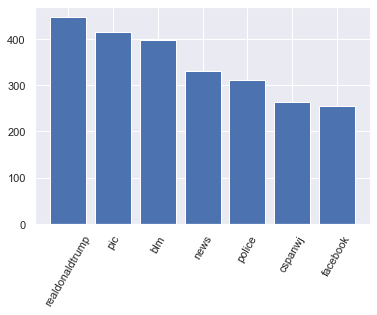

In [163]:
#graphing of topic 2
#NEUTRAL SENTIMENT
o=dict(sort_orders[0:7])
# o_items()
x, y = zip(*o.items()) # unpack a list of pairs into two tuples
plt.savefig('LDA_neu2.png')
plt.bar(x, y)
plt.xticks(rotation=60)
plt.show()

In [164]:
o.items()

dict_items([('realdonaldtrump', 447.4402190589659), ('pic', 414.86871552838693), ('blm', 396.99860773031315), ('news', 330.1342504707113), ('police', 310.8767244664168), ('cspanwj', 262.67991471247194), ('facebook', 254.59403662048186)])

In [165]:
# was able to calculate mean word length of all tweets
Sum=162388
length_numbers=4881

In [166]:
mean= Sum/length_numbers
mean

33.26941200573653

### Implementing pyLDAvis in my EDA

In [167]:
import gensim
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [168]:
# ! pip install pandas nltk gensim pyldavis
# Ignore warnings

In [169]:
#importing necessary libraries
#the cleaning function
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string

# stopwords = list([stopwords.words('english'),'alllivesmatter', 'blacklivesmatter', 'alllivesmatter'] )
# stopwords += ['alllivesmatter', 'blacklivesmatter', 'alllivesmatter']
punctuation = set(string.punctuation) 
lemmatize = WordNetLemmatizer()

def cleaning(article):
    one = " ".join([i for i in article.lower().split() if i not in sw_list])
    two = "".join(i for i in one if i not in punctuation)
    three = " ".join(lemmatize.lemmatize(i) for i in two.split())
    return three


In [170]:
#cleaning data and preprocessing
text = [cleaning(x) for x in Work_data['tweet']]
text_list = [i.split() for i in text]
len(text_list)

4881

In [171]:
text_list[0]

['httpstwittercomdrawandstrikestatus1279805238556397569s19',
 '…',
 'let',
 'know',
 'blm',
 'marxist',
 'scum',
 'marching',
 'little',
 'girl',
 '6000',
 'black',
 'people',
 'murdered',
 'black',
 'people',
 'u',
 'every',
 'year',
 'till',
 'then',
 'alllivesmatter']

In [172]:
# Importing Gensim
import gensim
from gensim import corpora

# Creating the term dictionary of our corpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
dictionary = corpora.Dictionary(text_list)
dictionary.save('dictionary.dict')


In [173]:
# creating and saving corpus to be used in the pyLDAvis  
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)


In [174]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [175]:
#Coding for the pyLDAviz
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
vis = pyLDAvis.gensim.prepare(ldamodel, c, d)
vis

/Users/jeffreyng/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.161480 -0.055781       1        1  16.066233
1     -0.031116  0.039180       2        1  13.295534
0     -0.163092 -0.065547       3        1  11.901338
6      0.018841  0.009837       4        1  11.547472
2      0.028408  0.026029       5        1   9.593911
5     -0.022784  0.005339       6        1   9.009373
4      0.050840  0.015683       7        1   8.328824
3      0.109569  0.017183       8        1   7.628012
8      0.023249  0.186250       9        1   6.955483
9      0.147565 -0.178172      10        1   5.673824, topic_info=     Category        Freq             Term       Total  loglift  logprob
26    Default  745.000000             life  745.000000  30.0000  30.0000
57    Default  501.000000           matter  501.000000  29.0000  29.0000
2     Default  707.000000            black  707.000000  28.0000  28.0000
287   Default  379.000000  realdonaldtrump  379.000000  27.0000  27.0000
279   Default  197.000000          cspanwj  197.000000  26.0000  26.0000
...       ...         ...              ...         ...      ...      ...
169   Topic10   11.895377           animal   56.978146   1.3028  -5.8985
438   Topic10   14.107561              get  279.185059  -0.1159  -5.7280
404   Topic10   13.277558             hate  209.590866   0.1102  -5.7886
1169  Topic10   12.215475             help   84.582863   0.9343  -5.8720
13    Topic10   13.291692           people  555.621643  -0.8636  -5.7876

[727 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
20       10  0.843306  1317
68        1  0.371310     2
68        6  0.077356     2
68        7  0.123770     2
68        8  0.293954     2
...     ...       ...   ...
3120      8  0.915341     👍
3584      6  0.947735     👏
5271      8  0.862171     😷
4280      5  0.947751    🙏🏻
5076      4  0.854572    🤣🤣

[1602 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 2, 1, 7, 3, 6, 5, 4, 9, 10])

### ^^^ The pyLDAvis using Gensim

In [176]:
# vis = pyLDAvis.gensim.prepare(ldamodel, c, d)
# pyLDAvis.save_html(vis, 'lda.html')